# Example Calculations

Some simple computations to demonstrate how the `lim` package works

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]

ModuleNotFoundError: No module named 'lim'

## The `LineModel` Object

The whole `lim` package is built on the `LineModel` class, which is initialized by the function `lim.lim()`.  This can be called without arguments to run a default model (in this case a CO(1-0) model based on arXiv:1609.01728), or it can be given arguments to define a wide range of possible models.


In [ ]:
# Initialize LineModel with default model
m = lim()

Input parameters can be specified in two ways: either by giving `lim()` a dict object as input, or by giving it a string containing the name of a dict from the included params.py file.

The default parameter values used can be seen in the `default_par` variable in params.py

In [3]:
# Example values of input parameters, in this case set from params.default_par

print('Emission Frequency:',m.nu) # Rest-frame emission frequency of CO(1-0) line
print('Observed Frequency:',m.nuObs) # Target observing frequency of modeled experiment
print('Assumed Cosmology:',m.cosmo_model) # Input cosmological model, typically from astropy.cosmology

Emission Frequency: 115.0 GHz
Observed Frequency: 30.0 GHz
Assumed Cosmology: Planck15


Most of the methods within LineModel and its subclasses are cached_property objects.  These are stored as methods until they are called the first time.  After they are called, the method is overwritten by its output, so none of the output quantities are computed more than once.

In [4]:
# Example output quantities

print('Target Redshift:',m.z) # Redshift corresponding to the given emission and observed frequencies
print('Hubble parameter:',m.H) # Hubble parameter at target redshift under given cosmo_model

Target Redshift: 2.8333333333333335
Hubble parameter: 288.2627430878539 km / (Mpc s)


In [5]:
m = lim() # Re-initializing lim() to make sure timing example works

# Output halo mass function.  Note difference in time between first and second evaluation
%time m.dndM
%time m.dndM

CPU times: user 8.81 s, sys: 141 ms, total: 8.95 s
Wall time: 276 ms
CPU times: user 17 µs, sys: 8 µs, total: 25 µs
Wall time: 49.1 µs


<Quantity [1.32289816e-09, 1.31570969e-09, 1.30856028e-09, ...,
           1.61026588e-33, 1.53398875e-33, 1.46132481e-33] 1 / (Mpc3 solMass)>

Input parameters of a LineModel can be changed using the `update()` method.  This will then recompute any cached_properties using the new parameter.  The original input parameters can be restored at any time using the `reset()` method.

In [6]:
print(m.z)

m.update(nuObs=15*u.GHz) # Note that parameters must include valid astropy unitts
print(m.z)

m.reset()
print(m.z)

2.8333333333333335
6.666666666666667
2.8333333333333335


## Modeling line emission

There are two ways to model the emission of a target line: We can either directly assume a luminosity function, or we can connect luminosity to some other galaxy property, typically halo mass.

These two options are controlled by the `model_type` input parameter.  If we're going to be connecting to dark matter simulations, we'll be using the mass-luminosity form.

Luminosity function models are set by `model_type='LF'`.  Possible models can be found in the luminosity_functions.py file.  Mass-based models are set by `model_type='ML`, and can be found in mass_luminosity.py

To call a model, give the name of the model as the `model_name` parameter, then the parameter values for the model as a dict in the `model_par` parameter.  `model_name` should be the name of a function in one of the two above files, you can examine the functions and the referenced papers to understand what parameters they take.

Model type: LF
Model name: SchCut
Model parameters: {'phistar': <Quantity 8.7e-11 1 / (Mpc3 solLum)>, 'Lstar': <Quantity 2100000. solLum>, 'alpha': -1.87, 'Lmin': <Quantity 5000. solLum>}


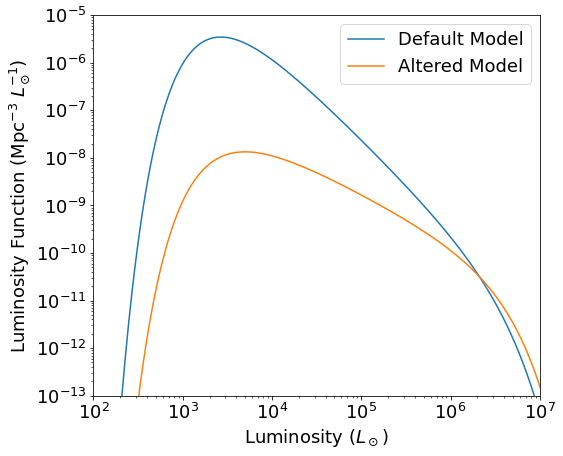

In [7]:
# Default 'LF' model
print('Model type:',m.model_type)
print('Model name:',m.model_name)
print('Model parameters:',m.model_par)

# Plot the luminosity function obtained from the default model, in this case a power law with 
# exponential cutoffs at both ends
plt.loglog(m.L,m.dndL,label='Default Model')
ax = plt.gca()
ax.set_ylim(1e-13,1e-5)
ax.set_xlim(1e2,1e7)
ax.set_xlabel('Luminosity ($L_\odot$)')
ax.set_ylabel('Luminosity Function (Mpc$^{-3}$ $L_\odot^{-1}$)')


# The model parameters can be updated just like any other input
# Parameters with different power law slope
new_par = dict(phistar=8.7e-11*u.Mpc**-3*u.Lsun**-1, Lstar=2.1e6*u.Lsun, alpha=-1., Lmin=5000.*u.Lsun)
m.update(model_par=new_par)
plt.loglog(m.L,m.dndL,label='Altered Model')

plt.legend()

Text(0, 0.5, 'Line Luminosity ($L_\\odot$)')

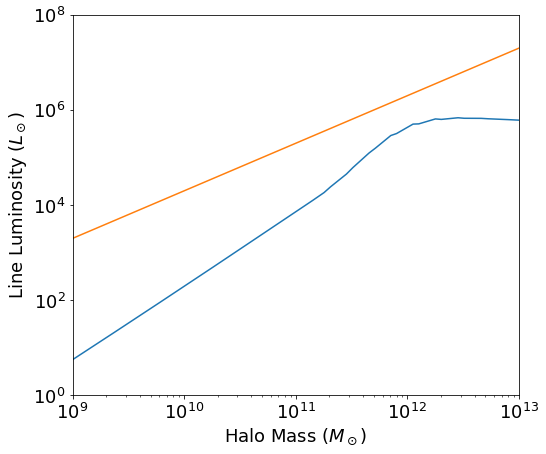

In [8]:
# Some example ML models:

m1 = lim('TonyLi_PhI') # Li et al. 2016 CO model for COMAP
m2 = lim(dict(model_type='ML',model_name='MassPow',model_par={'A':2e-6,'b':1})) # Simple power law



# Plot mass-luminosity relations
plt.loglog(m1.M,m1.LofM,label='Li2016')
plt.loglog(m2.M,m2.LofM,label='Power Law')

ax = plt.gca()
ax.set_xlim(1e9,1e13)
ax.set_ylim(1e0,1e8)
ax.set_xlabel('Halo Mass ($M_\odot$)')
ax.set_ylabel('Line Luminosity ($L_\odot$)')

## Analytic Statistics

Once we have a model in place, we can compute statistics we would expect from a map.  Most commonly, we use the power spectrum, defined in several references, derived fully in the appendix of arXiv:1904.03197

Text(0, 0.5, 'Power Spectrum (Mpc$^3$ $\\mu$K$^2$)')

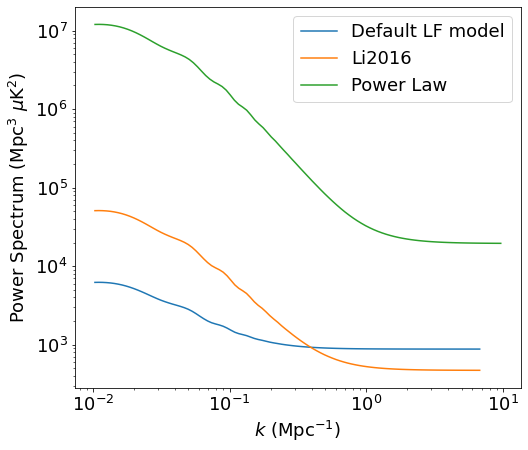

In [9]:
# Power spectra for the different CO models

plt.loglog(m.k,m.Pk,label='Default LF model')
plt.loglog(m1.k,m1.Pk,label='Li2016')
plt.loglog(m2.k,m2.Pk,label='Power Law')

plt.legend()

ax = plt.gca()
ax.set_xlabel('$k$ (Mpc$^{-1}$)')
ax.set_ylabel('Power Spectrum (Mpc$^3$ $\mu$K$^2$)')

## Limlam mocker

`lim` includes a version of the limlam_mocker code (https://github.com/georgestein/limlam_mocker) used for generating simulated intensity maps from input halo catalogues.  The lim version can be found in the limlam.py file.

To use these methods, give 'doSim=True' as an input to lim(), and give as an input parameter the name of the file containing the halo catalogue.  One of these can be found in limlam_mocker/catalogues/default_catalogue.npz designed for a survey at $z\sim3$

In [10]:
m1 = lim('TonyLi_PhI',doSim=True) # Li et al. 2016 CO model for COMAP

# Change survey parameters a bit to make map visualize better
# m1.update(beam_FWHM=10*u.arcmin,dnu=100*u.MHz)

# Note that if input cosmo_model does not match that used to make the halo catalogue it will be changed
# by default.  Set match_sim_cosmo=False if you don't want this to happen

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


The `maps` property contains the simulated intensity map in the form of a 3D numpy array corresponding to a measured data cube

In [11]:
fig = plt.figure(figsize=[8,7])

from scipy.ndimage import gaussian_filter1d

<Figure size 576x504 with 0 Axes>

In [12]:
# Note, this cell may take a few minutes the first time
pix = m1.maps

Loading .npz catalogues...


/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/limlam_mocker/load_halos.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  setattr(halos,i,getattr(halos,i)[dm])


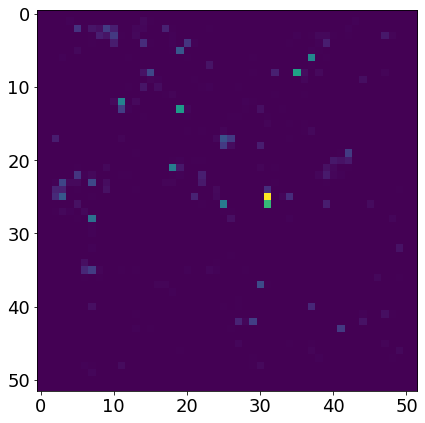

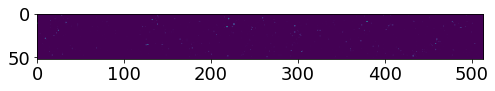

In [13]:
plt.imshow((m1.maps[:,:,1].value)) # View in the plane of the sky.  Note that imshow doesn't like astropy quantities,
                               # so we give it the value of pix
plt.figure()
plt.imshow(m1.maps[1,:,:].value)

## Exploring SFR computation

In [3]:
pwd

'/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/limlam_mocker'

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate
import sys
import os
import debug
import tools

import astropy.units as u

import mass_luminosity as ml
import luminosity_functions as lf

ImportError: attempted relative import with no known parent package

In [33]:
llm.get_sfr_table()

In [37]:
__file__ = '/limlam_mocker/limlam_mocker/halos_to_luminosity.py'

In [40]:
tablepath = os.path.dirname(os.path.dirname(os.path.realpath(__file__)))
tablepath

'/limlam_mocker'

In [38]:
tablepath = os.path.dirname(os.path.dirname(os.path.realpath(__file__)))
tablepath+= '/tables/sfr_behroozi_release.dat'
dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)

FileNotFoundError: [Errno 2] No such file or directory: '/limlam_mocker/tables/sfr_behroozi_release.dat'

In [31]:
__file__

NameError: name '__file__' is not defined

You can find more tools for working with the maps in limlam.py

## Possible Exercises

1. Experiment with different models and how they affect different aspects of the power spectrum.  Try to understand where the different pieces come from


2. Try to reproduce the power spectra from https://arxiv.org/pdf/1811.01968.pdf


3. limlam contains methods for computing various quantities from the simulations, including mass functions and power spectra.  Compare these to the analytic versions from LineModel and try to understand why they're different


4. LineObs contains methods for computing instrumenal effects, ultimately outputting m.sk, the error on a power spectrum at a given k.  Try to understand what goes into this.  https://arxiv.org/abs/1503.08833 and https://arxiv.org/abs/1812.08135 are good references


## My stuff

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]

### Reproducing Silva+2015 Figures

In [16]:
m1_s1 = lim('Silva_m1_z6_CCATp',doSim=True)
m1_s2 = lim('Silva_m2_z6_CCATp',doSim=True)
m1_s3 = lim('Silva_m3_z6_CCATp',doSim=True)
m1_s4 = lim('Silva_m4_z6_CCATp',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation
Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [17]:
k_s1 = m1_s1.k_sim
Pk_s1 = m1_s1.Pk_sim

Loading .npz catalogues...


/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:614: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [18]:
k_s2 = m1_s2.k_sim
Pk_s2 = m1_s2.Pk_sim

Loading .npz catalogues...


In [19]:
k_s3 = m1_s3.k_sim
Pk_s3 = m1_s3.Pk_sim

Loading .npz catalogues...


In [20]:
k_s4 = m1_s4.k_sim
Pk_s4 = m1_s4.Pk_sim

Loading .npz catalogues...


In [21]:
new_P_s1 = ((k_s1**3)*Pk_s1)/(2*(np.pi**2))
new_P_s2 = ((k_s2**3)*Pk_s2)/(2*(np.pi**2))
new_P_s3 = ((k_s3**3)*Pk_s3)/(2*(np.pi**2))
new_P_s4 = ((k_s4**3)*Pk_s4)/(2*(np.pi**2))

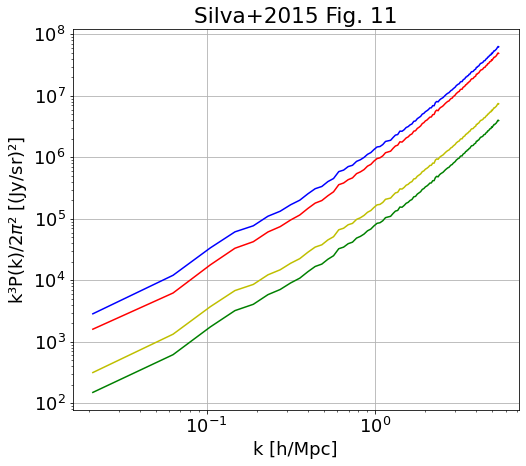

In [22]:
plt.plot(k_s1/0.7, new_P_s1, 'b')
plt.plot(k_s2/0.7, new_P_s2, 'r')
plt.plot(k_s3/0.7, new_P_s3, 'y')
plt.plot(k_s4/0.7, new_P_s4, 'g')

plt.xscale("log")
plt.yscale("log")
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k³P(k)/2$\pi$² [(Jy/sr)²]')
plt.title('Silva+2015 Fig. 11')

plt.savefig('Silva2015_fig11.pdf')

plt.grid()

In [23]:
int1 = m1_s1.maps
int2 = m1_s2.maps
int3 = m1_s3.maps
int4 = m1_s4.maps

In [24]:
mean_i_1 = np.mean(int1, axis=0)
mean_i_2 = np.mean(int2, axis=0)
mean_i_3 = np.mean(int3, axis=0)
mean_i_4 = np.mean(int4, axis=0)

In [25]:
mean_ij_1 = np.mean(mean_i_1, axis=0)
mean_ij_2 = np.mean(mean_i_2, axis=0)
mean_ij_3 = np.mean(mean_i_3, axis=0)
mean_ij_4 = np.mean(mean_i_4, axis=0)

In [26]:
nu_obs = m1_s1.mapinst.nu_bincents

In [27]:
z = (1897/nu_obs) - 1

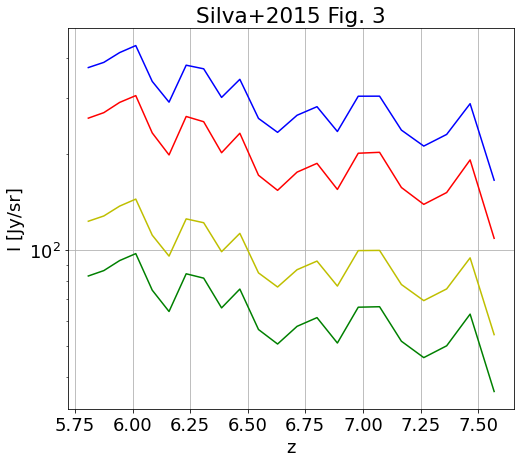

In [28]:
plt.plot(z, mean_ij_1, 'b')
plt.plot(z, mean_ij_2, 'r')
plt.plot(z, mean_ij_3, 'y')
plt.plot(z, mean_ij_4, 'g')

plt.yscale("log")
plt.xlabel('z')
plt.ylabel('I [Jy/sr]')
plt.title('Silva+2015 Fig. 3')

plt.savefig('Silva2015_fig3.pdf')

plt.grid()

### Reproducing Li+2016 Fig. 3

In [29]:
m1_l = lim('TonyLi_PhI',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [30]:
k_l = m1_l.k_sim
Pk_l = m1_l.Pk_sim

Loading .npz catalogues...


/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/limlam_mocker/load_halos.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  setattr(halos,i,getattr(halos,i)[dm])


In [31]:
new_P_l = ((k_l**3)*Pk_l)/(2*(np.pi**2))

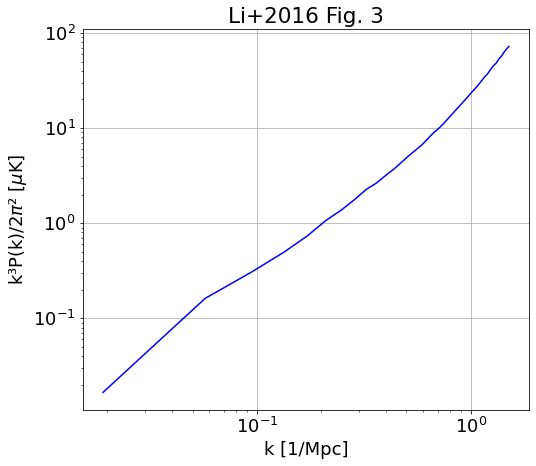

In [32]:
plt.plot(k_l, new_P_l, 'b')
plt.yscale("log")
plt.xscale("log")

plt.xlabel("k [1/Mpc]")
plt.ylabel(r"k³P(k)/2$\pi$² [$\mu$K]")
plt.title('Li+2016 Fig. 3')

plt.savefig('Li2016_fig3.pdf')

plt.grid()

### Reproducing Padmanabhan Fig. 2

In [33]:
m1_p = lim('Hamsa_CII',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [34]:
int_p = m1_p.maps

Loading .npz catalogues...


/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/limlam_mocker/load_halos.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  setattr(halos,i,getattr(halos,i)[dm])


In [35]:
mean_i_p = np.mean(int_p, axis=0)
mean_ij_p = np.mean(mean_i_p, axis=0)

In [36]:
nu_obs_p = m1_p.mapinst.nu_bincents

In [37]:
z_p = (1897/nu_obs_p) - 1

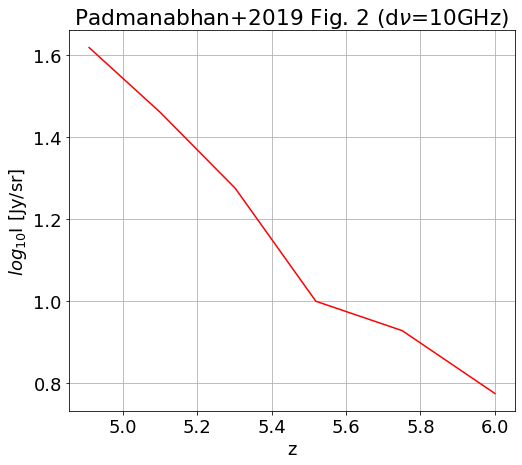

In [38]:
plt.plot(z_p, np.log10(mean_ij_p.value), 'r')

plt.xlabel('z')
plt.ylabel(r'$log_{10}$I [Jy/sr]')
plt.title(r'Padmanabhan+2019 Fig. 2 (d$\nu$=10GHz)')

plt.savefig('Padmanabhan2019_fig2.pdf')

plt.grid()

### Reproducing Padmanabhan Fig.6

In [42]:
k_p = m1_p.k_sim
Pk_p = m1_p.Pk_sim

In [43]:
new_P_p = ((k_p**3)*Pk_p)/(2*(np.pi**2))

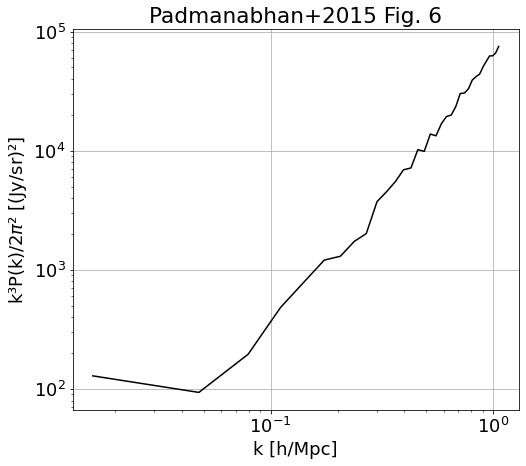

In [44]:
plt.plot(k_p/0.7, new_P_p, 'k')

plt.xscale("log")
plt.yscale("log")
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k³P(k)/2$\pi$² [(Jy/sr)²]')
plt.title('Padmanabhan+2015 Fig. 6')

plt.savefig("Padmanabhan2019_fig6.pdf")

plt.grid()

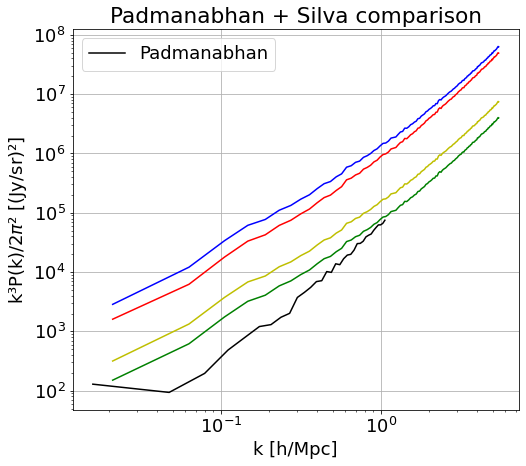

In [45]:
plt.plot(k_s1/0.7, new_P_s1, 'b')
plt.plot(k_s2/0.7, new_P_s2, 'r')
plt.plot(k_s3/0.7, new_P_s3, 'y')
plt.plot(k_s4/0.7, new_P_s4, 'g')
plt.plot(k_p/0.7, new_P_p, 'k', label='Padmanabhan')

plt.xscale("log")
plt.yscale("log")
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k³P(k)/2$\pi$² [(Jy/sr)²]')
plt.title('Padmanabhan + Silva comparison')

plt.savefig('PadmaSilva.pdf')

plt.legend()
plt.grid()

### Checking the max/min redshift of the simulated lightcone

In [46]:
simul = np.load('/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [47]:
print(simul.files)

['cosmo_header', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M', 'zhalo', 'zform', 'zcos']


In [48]:
np.min(simul['zhalo'])

5.564179000948425

In [49]:
np.max(simul['zhalo'])

8.28830662440266

## Continuing exploration of Clara's limlam

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]

In [2]:
# Initialize LineModel with default model
m = lim()

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [3]:
from scipy.ndimage import gaussian_filter1d

In [4]:
m1 = lim('TonyLi_PhI',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [5]:
fig = plt.figure(figsize=[8,7])

from scipy.ndimage import gaussian_filter1d

<Figure size 576x504 with 0 Axes>

Loading .npz catalogues...


/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/limlam_mocker/load_halos.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  setattr(halos,i,getattr(halos,i)[dm])


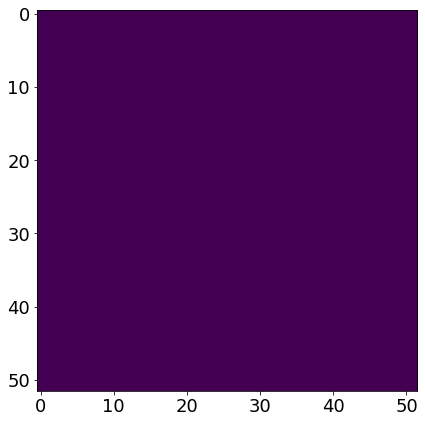

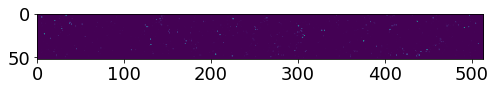

In [6]:
# Note, this cell may take a few minutes the first time
pix = m1.maps

plt.imshow((m1.maps[:,:,1].value)) # View in the plane of the sky.  Note that imshow doesn't like astropy quantities,
                               # so we give it the value of pix
plt.figure()
plt.imshow(m1.maps[1,:,:].value)

(0.0, 20.0)

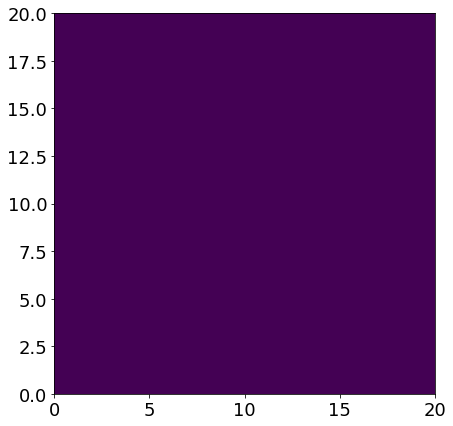

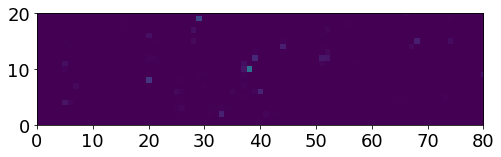

In [21]:
# Note, this cell may take a few minutes the first time
pix = m1.maps

plt.imshow((m1.maps[:,:,1].value)) # View in the plane of the sky.  Note that imshow doesn't like astropy quantities,
plt.ylim([0, 20])                  # so we give it the value of pix
plt.xlim([0, 20])

plt.figure()
plt.imshow(m1.maps[1,:,:].value)
plt.xlim([0, 80])
plt.ylim([0, 20])

In [19]:
m1.maps[20,:,5].value

array([ 0.        ,  0.        ,  0.        ,  0.58729148,  0.        ,
        0.        ,  0.        ,  1.34317681, 11.68842187,  2.19601742,
        0.02511724,  0.1109686 ,  0.39177352,  0.03291823,  0.17655765,
        0.        ,  0.        , 18.94102306,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.37640333,  0.38952462,
        0.        ,  0.13054599,  0.        ,  0.        ,  0.        ,
        0.15331877,  0.        ,  0.        ,  0.        ,  0.        ,
        0.09858017,  0.        ,  0.        ,  0.        ,  0.15265381,
        0.06468925,  0.04043489,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [13]:
print('He')

He
